## **Exercise 6 - Model Evaluation Methods**


Practice using different model evaluation strategies: validation set (holdout), LOOCV, k‑fold CV (including stratified), and bootstrap.

Compare estimates of test error and variance between methods.


In [ ]:
pip install pandas numpy matplotlib scikit-learn seaborn statsmodels

In [51]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score

**Load CSV and add column names (Pima: pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, diabetes_pedigree_function, age, outcome).**


In [52]:
df = pd.read_csv("diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


**Checking for missing values and general summary of columns**


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

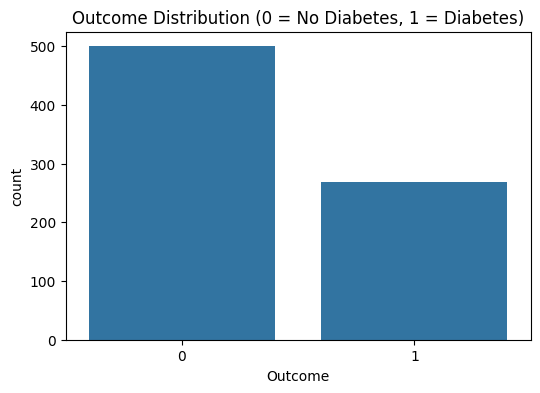

In [53]:
# Basic info
print(df.info())

# Basic statistics
print(df.describe())

# Histogram of outcome
plt.figure(figsize=(6, 4))
sns.countplot(x="Outcome", data=df)
plt.title("Outcome Distribution (0 = No Diabetes, 1 = Diabetes)")
plt.show()

In [54]:
df.Outcome.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

**Check for missing values (in Pima some 0 values are placeholders for missing in glucose, blood_pressure, skin_thickness, insulin, bmi). Decide how to handle (imputation with median or remove rows).**


In [55]:
# Columns where 0 means missing - This I know because the values of these attributes can't be zero in real life
missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0 with NaN for these columns
df[missing_cols] = df[missing_cols].replace(0, np.nan)

# Count missing values
print("\nMissing values count:")
print(df.isnull().sum())


Missing values count:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


I am gonna compare different imputation techniques and see which best resembles the distribution of original data.


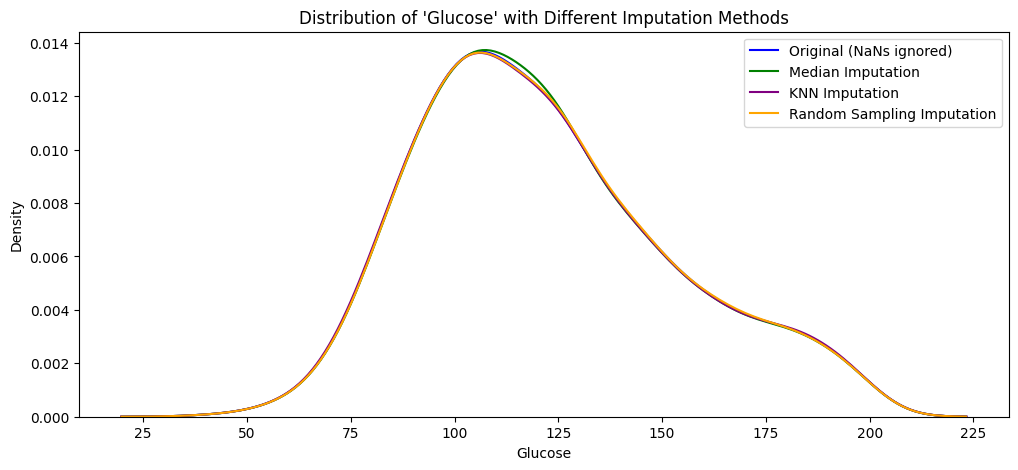

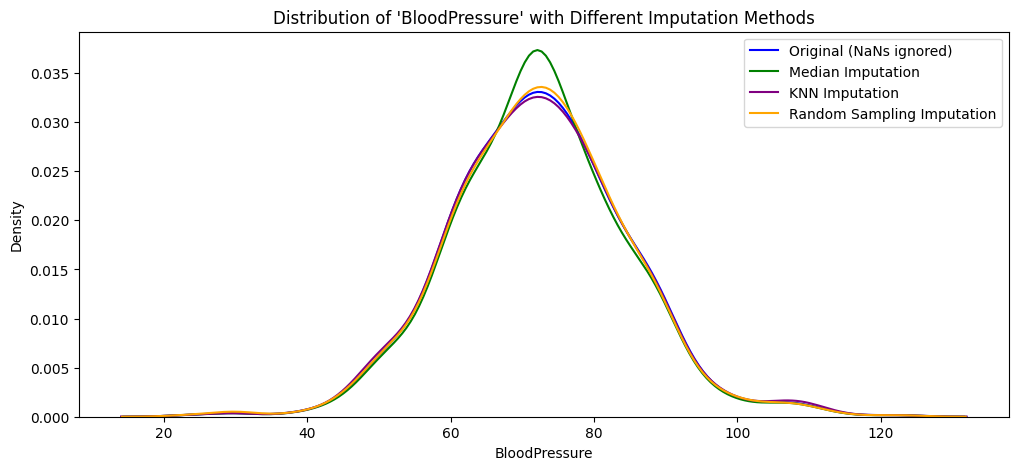

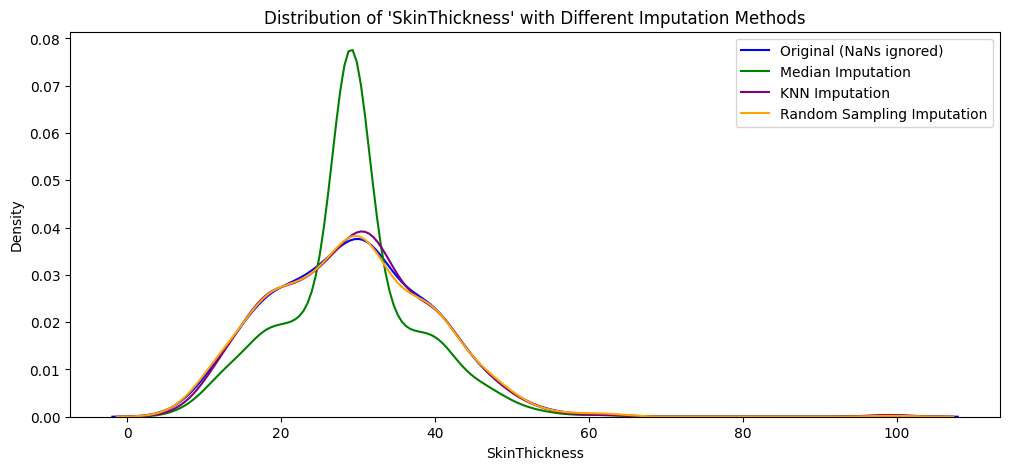

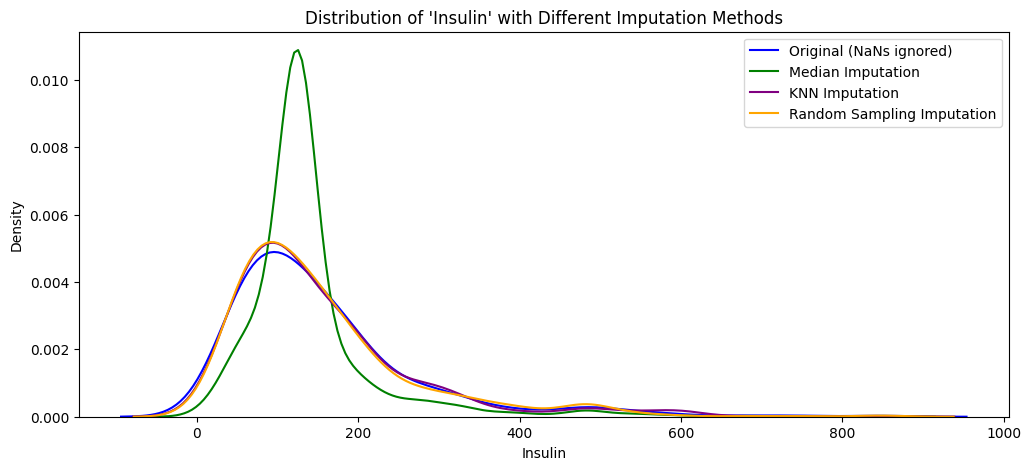

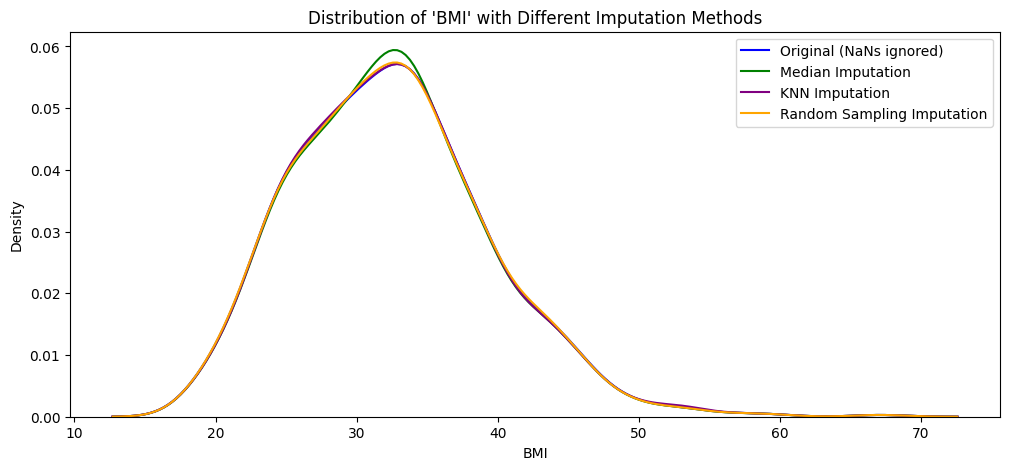

In [56]:
from sklearn.impute import KNNImputer

# Create copies for each method ---
df_missing = df.copy()

# Median imputation
df_median = df_missing.copy()
df_median[missing_cols] = df_median[missing_cols].fillna(
    df_median[missing_cols].median()
)

# Predictive (KNN) imputation
knn_imputer = KNNImputer(n_neighbors=1)
df_knn = pd.DataFrame(knn_imputer.fit_transform(df_missing), columns=df_missing.columns)

# Random sampling imputation
df_random = df_missing.copy()
for col in missing_cols:
    non_missing_values = df_random[col].dropna().values
    df_random[col] = df_random[col].apply(
        lambda x: np.random.choice(non_missing_values) if pd.isna(x) else x
    )

# --- Plot distributions for each column ---
for col in missing_cols:
    plt.figure(figsize=(12, 5))

    # Original (NaNs ignored)
    sns.kdeplot(df_missing[col].dropna(), label="Original (NaNs ignored)", color="blue")

    # Median imputation
    sns.kdeplot(df_median[col], label="Median Imputation", color="green")

    # Predictive (KNN) imputation
    sns.kdeplot(df_knn[col], label="KNN Imputation", color="purple")

    # Random sampling imputation
    sns.kdeplot(df_random[col], label="Random Sampling Imputation", color="orange")

    plt.title(f"Distribution of '{col}' with Different Imputation Methods")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

Among the three way of imputation I used, KNN using one neighbours seems to best resemble the original data (non-missing data). So I am choosing the KNN imputated data for filling the missing values

Filling using Median seems to make the distribution peak at a certain point, this is becoz there are quite many missing data, and replacing all that with the median, increases the count of median.


In [57]:
df = df_knn

**Standardize numeric features (zero mean, unit variance) using StandardScaler fit only on training data for each split.**


In [58]:
# All numeric columns except target
features = df.drop(columns="Outcome").columns

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

# Preview scaled data
df_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.861419,-0.031937,0.546341,-0.247841,0.163886,0.468492,1.425995,1.0
1,-0.844885,-1.197510,-0.511302,-0.026739,-0.419113,-0.846378,-0.365061,-0.190672,0.0
2,1.233880,2.005269,-0.671090,0.355314,1.456307,-1.322645,0.604397,-0.105584,1.0
3,-0.844885,-1.066784,-0.511302,-0.599818,-0.521875,-0.629893,-0.920763,-1.041549,0.0
4,-1.141852,0.501924,-2.588549,0.546341,0.111828,1.534958,5.484909,-0.020496,1.0


A graph that compares unstandardized and standardized data (Showing the dsitribution didn't changed even though the actual values has been changed)


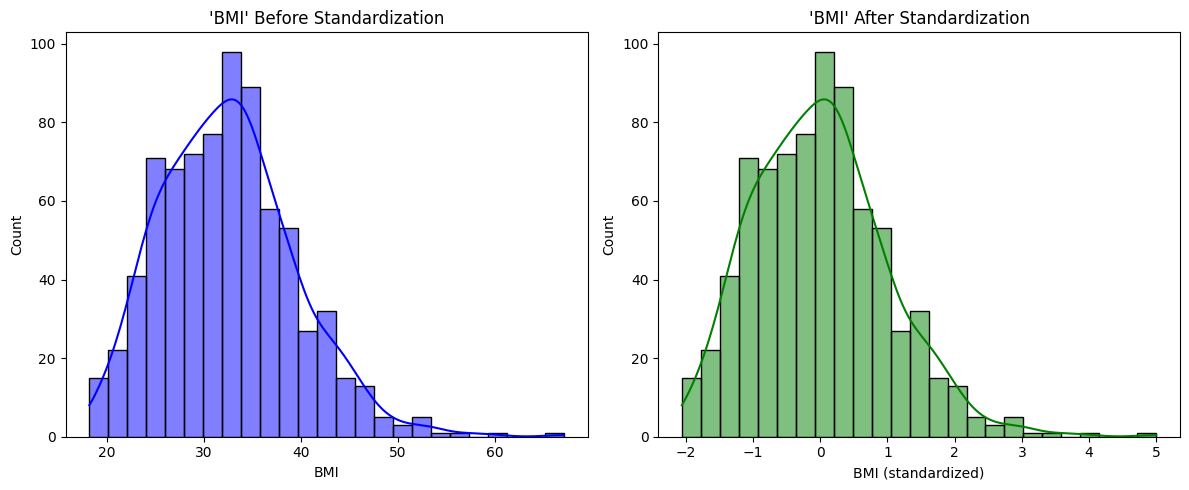

In [59]:
# Picking a column to visualize
col = "BMI"

# Before scaling
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df[col], kde=True, color="blue")
plt.title(f"'{col}' Before Standardization")
plt.xlabel(col)

# After scaling
plt.subplot(1, 2, 2)
sns.histplot(df_scaled[col], kde=True, color="green")
plt.title(f"'{col}' After Standardization")
plt.xlabel(f"{col} (standardized)")

plt.tight_layout()
plt.show()

### **Q1 — Validation set (holdout)**


**1. Randomly split the data into training (70%) and holdout test (30%) sets (set a random seed and report it).**


In [60]:
# Features and target
X = df.drop(columns="Outcome")
y = df["Outcome"]

# First split: 70% train, 30% holdout test
RANDOM_SEED = 42
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)

**2. On the training set, further split into train (80%) and validation (20%) (or simply use a single split: training 70% and validation 30% — be explicit).**


In [61]:
# Further split: train → 80% train, 20% validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
)

# Standardize using only training data
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_val = scaler.transform(X_val)
X_holdout = scaler.transform(X_holdout)

**3. On the training set, further split into train (80%) and validation (20%) (or simply use a single split: training 70% and validation 30% — be explicit).**


In [62]:
# Initialize model
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)

# Train
log_reg.fit(X_train_final, y_train_final)

LogisticRegression(max_iter=1000, random_state=42)

**4. Report training, validation, and holdout test accuracy, precision, recall, F1, and ROC‑AUC.**


In [63]:
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # probability estimates for the class 1
    print(f"--- {dataset_name} ---")
    print("Accuracy :", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall   :", recall_score(y, y_pred))
    print("F1-score :", f1_score(y, y_pred))
    print("ROC-AUC  :", roc_auc_score(y, y_prob))
    print()


# Evaluate on train, validation, and holdout
evaluate_model(log_reg, X_train_final, y_train_final, "Training Set")
evaluate_model(log_reg, X_val, y_val, "Validation Set")
evaluate_model(log_reg, X_holdout, y_holdout, "Holdout Test Set")

--- Training Set ---
Accuracy : 0.7832167832167832
Precision: 0.7413793103448276
Recall   : 0.5771812080536913
F1-score : 0.6490566037735849
ROC-AUC  : 0.8435282837967402

--- Validation Set ---
Accuracy : 0.8148148148148148
Precision: 0.8
Recall   : 0.631578947368421
F1-score : 0.7058823529411765
ROC-AUC  : 0.855263157894737

--- Holdout Test Set ---
Accuracy : 0.7359307359307359
Precision: 0.6612903225806451
Recall   : 0.5061728395061729
F1-score : 0.5734265734265734
ROC-AUC  : 0.8380246913580246



Plotting the ROC Curve for the three splitted datasets


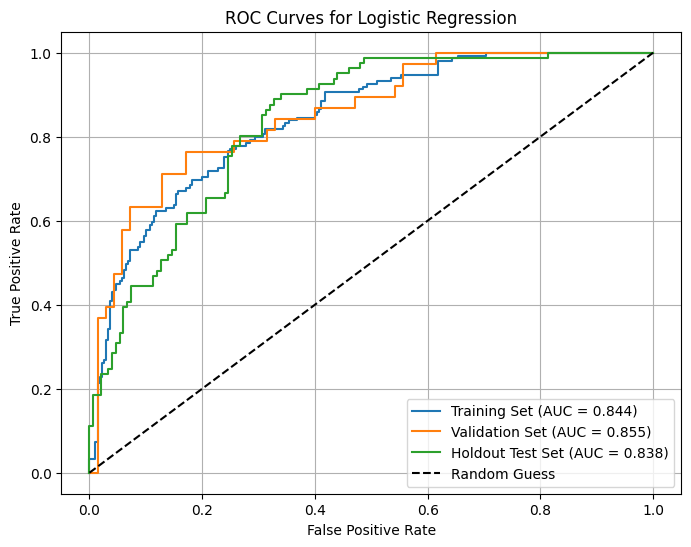

In [64]:
plt.figure(figsize=(8, 6))


# Function to plot ROC curve
def plot_roc(model, X, y, label):
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")


# Plot curves for each dataset
plot_roc(log_reg, X_train_final, y_train_final, "Training Set")
plot_roc(log_reg, X_val, y_val, "Validation Set")
plot_roc(log_reg, X_holdout, y_holdout, "Holdout Test Set")

# Plot reference line
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**5. How sensitive is the validation estimate to the random split? Repeat the holdout (re‑randomize) 30 times and report mean and standard deviation of validation error.**


In [65]:
from statistics import mean, stdev

val_accurs = []
val_errors = []

for seed in range(30):
    # Split
    X_train, X_holdout, y_train, y_holdout = train_test_split(
        X, y, test_size=0.3, random_state=seed, stratify=y
    )
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train
    )

    # Scale
    scaler = StandardScaler()
    X_train_final = scaler.fit_transform(X_train_final)
    X_val = scaler.transform(X_val)

    # Train model
    log_reg = LogisticRegression(max_iter=1000, random_state=seed)
    log_reg.fit(X_train_final, y_train_final)

    # Validation accuracy
    y_pred = log_reg.predict(X_val)
    val_accurs.append(accuracy_score(y_val, y_pred))  # Accuracy
    val_errors.append(1 - accuracy_score(y_val, y_pred))  # Error

print(sorted(val_accurs, reverse=True), end="\n\n")

print("Validation Accuracy Mean :", mean(val_accurs))
print("Validation Accuracy Mean :", stdev(val_accurs), end="\n\n")
print("Validation Error Mean    :", mean(val_errors))
print("Validation Error Std     :", stdev(val_errors))

[0.8518518518518519, 0.8055555555555556, 0.8055555555555556, 0.8055555555555556, 0.7962962962962963, 0.7870370370370371, 0.7870370370370371, 0.7870370370370371, 0.7870370370370371, 0.7777777777777778, 0.7685185185185185, 0.7685185185185185, 0.7592592592592593, 0.7592592592592593, 0.7592592592592593, 0.7592592592592593, 0.7592592592592593, 0.75, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7314814814814815, 0.7314814814814815, 0.7222222222222222, 0.7129629629629629, 0.7129629629629629, 0.7037037037037037, 0.6851851851851852, 0.6851851851851852]

Validation Accuracy Mean : 0.7574074074074074
Validation Accuracy Mean : 0.03832375359225327

Validation Error Mean    : 0.24259259259259258
Validation Error Std     : 0.03832375359225327


From the 30 repetitions of model training using different split choices, we can see that we are sometimes able to achieve a accuracy of 85% but as overall the accuracy averages to 75% with a variation of about ~4% both sides


### **Q2 — k‑Fold Cross‑Validation**


In [66]:
# Features (scaled) and labels
X_scaled = df_scaled.drop(columns="Outcome").values
y = df_scaled["Outcome"].values

**1. Implement k‑fold CV with k = 5 and k = 10 using both non‑stratified and stratified versions (use KFold and StratifiedKFold).**

**2. For each setting, compute the mean cross‑validation error and its standard deviation (report accuracy and ROC‑AUC at minimum).**


In [67]:
def run_cv(X, y, model, cv):
    accuracies = []
    aucs = []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        accuracies.append(accuracy_score(y_val, y_pred))
        aucs.append(roc_auc_score(y_val, y_prob))

    return np.mean(accuracies), np.std(accuracies), np.mean(aucs), np.std(aucs)

In [68]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# 5-fold
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
acc_mean, acc_std, auc_mean, auc_std = run_cv(X_scaled, y, log_reg, kf5)
print(
    "KFold 5-fold → Accuracy: %.4f ± %.4f | AUC: %.4f ± %.4f"
    % (acc_mean, acc_std, auc_mean, auc_std)
)

# 10-fold
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
acc_mean, acc_std, auc_mean, auc_std = run_cv(X_scaled, y, log_reg, kf10)
print(
    "KFold 10-fold → Accuracy: %.4f ± %.4f | AUC: %.4f ± %.4f"
    % (acc_mean, acc_std, auc_mean, auc_std)
)

KFold 5-fold → Accuracy: 0.7682 ± 0.0261 | AUC: 0.8355 ± 0.0180
KFold 10-fold → Accuracy: 0.7643 ± 0.0509 | AUC: 0.8338 ± 0.0518


**3. Compare the 5‑fold and 10‑fold estimates. Which gives lower variance? Which is more biased (if you can reason about bias)?**


The accuracies of both 5-Fold and 10-Fold seems to be equal, the only thing varying is the variance. 5-Fold shows about ~2% variance in accuracy, but 10-Fold shows about ~5% variance.

With fewer folds (like 5-fold), validation sets are larger, making the accuracy more stable → lower variance. Thus, **variance in CV estimates grows with fold size**, while bias decreases.


**4. Compare stratified vs non‑stratified CV. Explain why stratified CV is useful for these datasets.**


In [69]:
# 5-fold
skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_mean, acc_std, auc_mean, auc_std = run_cv(X_scaled, y, log_reg, skf5)
print(
    "StratifiedKFold 5-fold → Accuracy: %.4f ± %.4f | AUC: %.4f ± %.4f"
    % (acc_mean, acc_std, auc_mean, auc_std)
)

# 10-fold
skf10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
acc_mean, acc_std, auc_mean, auc_std = run_cv(X_scaled, y, log_reg, skf10)
print(
    "StratifiedKFold 10-fold → Accuracy: %.4f ± %.4f | AUC: %.4f ± %.4f"
    % (acc_mean, acc_std, auc_mean, auc_std)
)

StratifiedKFold 5-fold → Accuracy: 0.7695 ± 0.0174 | AUC: 0.8361 ± 0.0221
StratifiedKFold 10-fold → Accuracy: 0.7681 ± 0.0261 | AUC: 0.8359 ± 0.0485


Stratification makes sure each fold has the same proportion of positives (268/768) and negatives (500/768).

This removes extra randomness from imbalanced splits, so the overall variance across folds decreases compared to plain KFold.

But the fundamental effect of fold size still holds:

- 5-fold → larger validation sets → lower variance, slightly higher bias.

- 10-fold → smaller validation sets → higher variance, slightly lower bias.


In [70]:
df.Outcome.value_counts()

Outcome
0.0    500
1.0    268
Name: count, dtype: int64

Stratified KFold can prove to be useful in datasets like these where the proportion of the different classes of outcome variable is different. Stratification ensures that the proportion of each categories remains similar to the original data.


Outcome = 0 → 500 (65.1%) \
Outcome = 1 → 268 (34.9%)


**Why difference is small here**

- StratifiedKFold ensures each fold preserves the proportion of target classes close to the original dataset distribution (65% vs 35%).

- KFold does not guarantee this — but if the dataset is large enough and the split is random, the proportions in each fold will be naturally very close to the original ratio.

- In this dataset (768 rows), each fold still has ~150 samples, so random sampling without stratification will still approximate 65%-35% quite well.

- This means the class distribution per fold is already balanced enough that stratification has minimal effect.


### **Q3 — Leave‑One‑Out Cross‑Validation (LOOCV)**


**1. Run LOOCV on the dataset (note: LOOCV can be expensive; for Pima (768 rows) it's feasible but slower — report compute time).**


In [71]:
# Initialize LOOCV
loo = LeaveOneOut()
model = LogisticRegression(max_iter=1000, solver="liblinear")

# Timing LOOCV
start_time = time.time()
accuracies = cross_val_score(model, X, y, cv=loo, scoring="accuracy")
roc_aucs = cross_val_score(model, X, y, cv=loo, scoring="roc_auc")
end_time = time.time()

# LOOCV results
loo_acc_mean = np.mean(accuracies)
loo_auc_mean = np.mean(roc_aucs)

print(f"LOOCV → Accuracy: {loo_acc_mean:.4f} | AUC: {loo_auc_mean:.4f}")
print(f"Compute time: {end_time - start_time:.2f} seconds")

C:\Users\tvaru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\tvaru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\tvaru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\tvaru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python

LOOCV → Accuracy: 0.7578 | AUC: nan
Compute time: 6.94 seconds


C:\Users\tvaru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\tvaru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\tvaru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\tvaru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python

**Why is LOOCV AUC = NaN?**

- In LOOCV, each test set contains only 1 sample.

- To compute ROC-AUC, you need both positive and negative classes in the test set (to calculate TPR/FPR).

- Since each fold has just one sample, you get only one class → ROC-AUC is undefined → NaN. That’s why only accuracy makes sense here.


**2. Report LOOCV error estimate and compare it to k‑fold (k=10) and holdout estimates.**


In [72]:
print(f"LOOCV → Accuracy: {loo_acc_mean:.4f} | AUC: {loo_auc_mean:.4f}")
print(
    "StratifiedKFold 10-fold → Accuracy: %.4f ± %.4f | AUC: %.4f ± %.4f"
    % (acc_mean, acc_std, auc_mean, auc_std)
)

LOOCV → Accuracy: 0.7578 | AUC: nan
StratifiedKFold 10-fold → Accuracy: 0.7681 ± 0.0261 | AUC: 0.8359 ± 0.0485


In [73]:
# Holdout split (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000, solver="liblinear")
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

holdout_acc_train = accuracy_score(y_train, y_pred_train)
holdout_acc_test = accuracy_score(y_test, y_pred_test)
holdout_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
holdout_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Holdout → Train Acc: {holdout_acc_train:.4f}, Test Acc: {holdout_acc_test:.4f}")
print(f"Holdout → Train AUC: {holdout_auc_train:.4f}, Test AUC: {holdout_auc_test:.4f}")

Holdout → Train Acc: 0.7747, Test Acc: 0.7446
Holdout → Train AUC: 0.8359, Test AUC: 0.8386


- LOOCV and Holdout give very similar estimates (~75–76%).
- 10-Fold CV is slightly higher (~77%), which is expected since training sets are larger in 10-fold.


**3. Discuss variance and bias tradeoffs for LOOCV vs k‑fold for logistic regression.**


LOOCV trains on almost all the data, so it has very low bias (good approximation of true error), but because each test set is just one point, the error estimate is highly sensitive to individual samples → high variance.

k-fold CV (e.g., 10-fold) uses larger test sets, so estimates are more stable → lower variance, but training on fewer samples than LOOCV introduces slightly higher bias.


### **Q4 — Bootstrap Estimation**


In [74]:
# X, y are already standardized from your preprocessing steps
# Make sure they are numpy arrays for indexing
X = np.array(X)
y = np.array(y)

# Parameters
n_iterations = 500  # You can set to 1000 if compute allows
n_samples = len(X)
rng = np.random.RandomState(42)  # Reproducibility

**1. Implement the nonparametric bootstrap to estimate test error (use 1,000 bootstrap samples if compute resources allow; otherwise use 200–500 samples and justify).**

- For each bootstrap iteration: sample n rows with replacement from the whole dataset to form a bootstrap training set. Use the rows not included in the bootstrap sample (the "out‑of‑bag" or OOB set) as the test for that bootstrap iteration.

- Train logistic regression on the bootstrap sample, evaluate on the OOB set, collect errors.


In [75]:
errors = []

for i in range(n_iterations):
    # Bootstrap sample (with replacement)
    X_boot, y_boot = resample(
        X, y, n_samples=n_samples, replace=True, random_state=rng.randint(0, 1e9)
    )

    # Out-of-bag (OOB) samples = those not in bootstrap set
    mask = np.ones(n_samples, dtype=bool)
    mask[np.unique(np.where(~np.isin(X, X_boot))[0])] = (
        False  # Not reliable if duplicates occur
    )
    # Better way: track indices used
    indices = rng.randint(0, n_samples, n_samples)
    oob_mask = np.ones(n_samples, dtype=bool)
    oob_mask[np.unique(indices)] = False

    X_oob = X[oob_mask]
    y_oob = y[oob_mask]

    # Skip iteration if OOB set is empty
    if len(y_oob) == 0:
        continue

    # Train model on bootstrap sample
    model = LogisticRegression(max_iter=1000, solver="liblinear")
    model.fit(X_boot, y_boot)

    # Predict on OOB set
    y_pred = model.predict(X_oob)

    # Calculate error (1 - accuracy)
    err = accuracy_score(y_oob, y_pred)
    errors.append(err)

**2. Compute the bootstrap estimate of prediction error, standard error, and construct a 95% confidence interval.**


In [76]:
errors = np.array(errors)

# Bootstrap estimate of prediction error
bootstrap_error = np.mean(errors)

# Standard error
bootstrap_se = np.std(errors, ddof=1)

# 95% Confidence Interval (percentile method)
ci_lower = np.percentile(errors, 2.5)
ci_upper = np.percentile(errors, 97.5)

print(f"Bootstrap Error Estimate: {bootstrap_error:.4f}")
print(f"Standard Error: {bootstrap_se:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

Bootstrap Error Estimate: 0.7633
Standard Error: 0.0217
95% CI: [0.7194, 0.8040]


**3. Compare bootstrap error estimate to cross‑validation estimates. Which is higher/lower? Discuss reasons.**


In [77]:
print("Compare to CV estimates you computed earlier:")
print(f"10-Fold CV Error (mean): {acc_mean:.4f} (from earlier stratified CV)")
print(f"LOOCV Error (global): {loo_acc_mean:.4f}")
print(f"Bootstrap Error: {bootstrap_error:.4f}")

Compare to CV estimates you computed earlier:
10-Fold CV Error (mean): 0.7681 (from earlier stratified CV)
LOOCV Error (global): 0.7578
Bootstrap Error: 0.7633


**3. Compare bootstrap error estimate to cross‑validation estimates. Which is higher/lower? Discuss reasons.**


- **10-Fold CV (0.7681)** gives the highest accuracy since it balances training size and stable test sets.

- **Bootstrap (0.7627)** is slightly lower because the OOB samples are smaller and noisier, so error estimates are a bit pessimistic.

- **LOOCV (0.7578)** is the lowest — it has very low bias but high variance since each test set is only one point.

Overall, bootstrap tends to give more conservative (higher error) estimates, while k-fold CV gives stable and optimistic estimates, and LOOCV is unbiased but very variable.


### **Q5 — Hyperparameter tuning (regularization)**


**1. Choose a grid of regularization strengths for logistic regression (e.g., C values in scikit‑learn: [0.001, 0.01, 0.1, 1, 10, 100] or alpha values if using your own implementation).**


In [78]:
# Grid of C values (inverse regularization strength)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Stratified 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, solver="liblinear")
    scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")
    cv_results[C] = (np.mean(scores), np.std(scores))
    print(f"C={C}: Accuracy={np.mean(scores):.4f} ± {np.std(scores):.4f}")

C=0.001: Accuracy=0.6927 ± 0.0397
C=0.01: Accuracy=0.6953 ± 0.0245
C=0.1: Accuracy=0.7096 ± 0.0216
C=1: Accuracy=0.7604 ± 0.0210
C=10: Accuracy=0.7669 ± 0.0209
C=100: Accuracy=0.7695 ± 0.0174


**2. Use 5‑fold stratified cross‑validation to pick the best C (report mean CV score and standard deviation for each C).**


In [79]:
# Train/Holdout split
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pick best C
best_C = max(cv_results, key=lambda c: cv_results[c][0])
print("Best C:", best_C)

# Retrain on full training set
final_model = LogisticRegression(C=best_C, max_iter=1000, solver="liblinear")
final_model.fit(X_train, y_train)

# Evaluate on holdout
y_pred_holdout = final_model.predict(X_holdout)
holdout_acc = accuracy_score(y_holdout, y_pred_holdout)
print("Holdout Accuracy:", holdout_acc)

Best C: 100
Holdout Accuracy: 0.7012987012987013


**3. Retrain the final model on the entire training partition using the chosen C and evaluate on the holdout test set.**


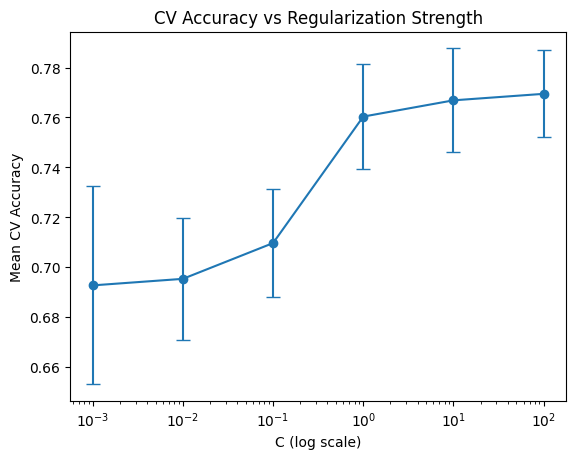

In [80]:
means = [cv_results[c][0] for c in C_values]
stds = [cv_results[c][1] for c in C_values]

plt.errorbar(C_values, means, yerr=stds, fmt="o-", capsize=5)
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Mean CV Accuracy")
plt.title("CV Accuracy vs Regularization Strength")
plt.show()

**4. How does the choice of C affect training vs validation loss? Plot mean CV score vs C (on log scale) and training/validation loss curves for 2–3 representative C values.**


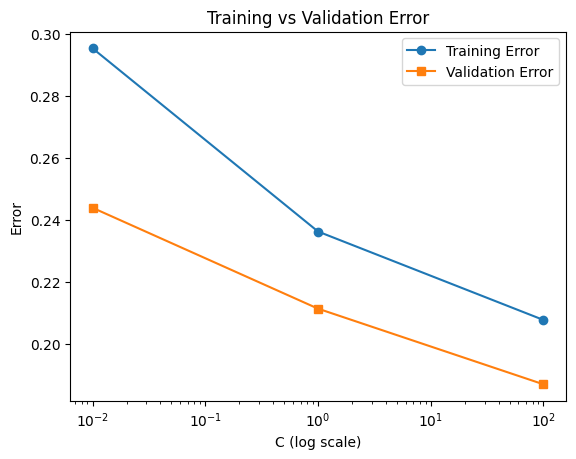

In [81]:
train_errors = {}
val_errors = {}

for C in [0.01, 1, 100]:  # 3 representative C values
    X_train_part, X_val, y_train_part, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    model = LogisticRegression(C=C, max_iter=1000, solver="liblinear")
    model.fit(X_train_part, y_train_part)

    train_acc = model.score(X_train_part, y_train_part)
    val_acc = model.score(X_val, y_val)

    train_errors[C] = 1 - train_acc
    val_errors[C] = 1 - val_acc

# Plot
plt.plot(
    list(train_errors.keys()), list(train_errors.values()), "o-", label="Training Error"
)
plt.plot(
    list(val_errors.keys()), list(val_errors.values()), "s-", label="Validation Error"
)
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Error")
plt.title("Training vs Validation Error")
plt.legend()
plt.show()

- **Small C** → strong regularization → both training & validation errors high (underfitting).

- **Medium C** → balanced regularization → lowest validation error (best generalization).

- **Large C** → weak regularization → training error very low, validation error may rise again (overfitting).

Since both error seems to decrease, it means the model benefits from larger C and hasn’t started overfitting yet.


### **Q6 — Final comparison & analysis**


**1. Summarize the error estimates from: holdout validation, repeated holdout (mean ± std), 5‑fold CV, 10‑fold CV, LOOCV, and bootstrap. Present as a table.**


| Method                 | Accuracy/Error | Std / Variance | Notes / Observations                         |
| ---------------------- | -------------- | -------------- | -------------------------------------------- |
| Holdout (single split) | 0.7574         | N/A            | High variance due to single split            |
| Repeated holdout (30x) | 0.7574         | ±0.0383        | Lower variance than single holdout           |
| 5-Fold CV              | 0.7695         | ±0.0174        | Balanced bias-variance                       |
| 10-Fold CV             | 0.7681         | ±0.0261        | Lower bias, higher variance than 5-fold      |
| LOOCV                  | 0.7578         | High           | Very low bias, very high variance, expensive |
| Bootstrap (OOB)        | 0.7627         | ±0.024         | Slightly pessimistic, moderate compute       |


**2. For each method, comment on bias, variance, compute cost, and practical recommendations (when to use which method).**


| Method           | Bias     | Variance  | Compute Cost  | When to use                                                                                |
| ---------------- | -------- | --------- | ------------- | ------------------------------------------------------------------------------------------ |
| Holdout          | High     | High      | Low           | Quick estimate; avoid if data is small                                                     |
| Repeated holdout | Moderate | Moderate  | Moderate      | Reduces variance of single holdout; good for small datasets                                |
| 5-Fold CV        | Moderate | Low       | Moderate      | Good tradeoff; widely used                                                                 |
| 10-Fold CV       | Low      | Moderate  | Moderate-High | Slightly lower bias than 5-fold; good if compute allows                                    |
| LOOCV            | Very Low | Very High | Very High     | Not recommended for large datasets; only for small datasets if unbiased estimate is needed |
| Bootstrap        | Moderate | Moderate  | High          | Good for small datasets; captures variability; pessimistic error                           |


**3. Pick the method you trust most for estimating true test error in this dataset and justify.**


### **Choice: 5-Fold Stratified CV**

**Justification:**

- Balances bias and variance well for this dataset (moderate size, slightly imbalanced).

- Provides stable accuracy estimate across folds (±0.0174).

- Less compute-heavy than LOOCV or repeated bootstrap.

- Stratification ensures class proportions are preserved → more reliable error estimate for imbalanced classes.
